In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
import os
from pathlib import Path
import re
import sys
import yaml
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from func.utils import get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename, logger_func
from ieee_train import eval_train, eval_check_feature
from kaggle_utils import reduce_mem_usage, move_feature
logger = logger_func()

2019-10-02 19:57:25,270 func.utils 347 [INFO]    [logger_func] start 


In [3]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMN_GROUP = 'DT-M'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, COLUMN_GROUP, 'is_train', 'date']

def filter_feature(path):
    if path.count(''):
        return True
    else:
        return False

# paths_train = glob('../submit/re_sub/50*_train.gz')
# paths_test  = glob('../submit/re_sub/50*_test.gz')
# paths_train += glob('../submit/re_sub/Tran*_train.gz')
# paths_test  += glob('../submit/re_sub/Tran*_test.gz')
# paths_train += glob('../submit/re_sub/is*_train.gz')
# paths_test  += glob('../submit/re_sub/is*_test.gz')

paths_train = glob('../submit/re_sub/*_train.gz')
paths_test  = glob('../submit/re_sub/*_test.gz')
# paths_train += glob('../submit/add_feature/*_train.gz')
# paths_test  += glob('../submit/add_feature/*_test.gz')

print(len(paths_train))
# sys.exit()
# paths_train += glob('../feature/valid_trush/528*uid2*_train.gz')
# paths_test  += glob('../feature/valid_trush/528*uid2*_test.gz')

# for path in paths_train:
#     if path.count('C14_ratio'):
#         paths_train.remove(path)
        
# for path in paths_test:
#     if path.count('C14_ratio'):
#         paths_test.remove(path)
    
# paths_train = glob('../feature/raw_use/*_train.gz')
# paths_test = glob('../feature/raw_use/*_test.gz')
# paths_train = [path for path in paths_train if filter_feature(path) ]
# paths_test = [path for path in paths_test if filter_feature(path) ]

# paths_train_feature = sorted(glob('../feature/org_use/*_train.gz'))
# paths_test_feature  = sorted(glob('../feature/org_use/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/valid/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/valid/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/kernel/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/kernel/*_test.gz'))

# paths_train_feature = sorted(glob('../feature/valid_use/*_train.gz'))
# paths_test_feature  = sorted(glob('../feature/valid_use/*_test.gz'))
paths_train_feature = []
paths_test_feature  = []

# df_train = reduce_mem_usage( parallel_load_data(paths_train) )
# df_test  = reduce_mem_usage( parallel_load_data(paths_test) )
df_train = parallel_load_data(paths_train)
df_test  = parallel_load_data(paths_test)
Y = df_train[COLUMN_TARGET]
df_train.drop(COLUMN_TARGET, axis=1, inplace=True)

1807


In [3]:
# same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
# same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
# bear = pd.read_csv(same_user_path)
# bear = bear[[COLUMN_ID, 'predicted_user_id']]
# max_id = bear['predicted_user_id'].max()
# bear.loc[bear[bear['predicted_user_id'].isnull()].index, 'predicted_user_id'] = np.arange(
#     bear['predicted_user_id'].isnull().sum() ) + 1 + max_id
# bear['predicted_user_id'] =  bear['predicted_user_id'].astype('int')
# bear.shape

In [4]:
is_submit = [True, False][0]
n_splits = 5
set_type = 'new_set'

valid_paths_train = paths_train_feature[:]
valid_paths_test  = paths_test_feature[:]

#========================================================================
# pathの存在チェック。なぜかたびたびFileNotFoundErrorが起きるので,,,
#========================================================================
remove_paths = []
for trn_path, tes_path in zip(valid_paths_train, valid_paths_test):
    if os.path.exists(trn_path) and os.path.exists(tes_path):
        pass
    else:
        remove_paths.append(trn_path)
        remove_paths.append(tes_path)
for path in remove_paths:
    if path.count('train'):
        valid_paths_train.remove(path)
        print(f'remove {path}')
    elif path.count('test'):
        valid_paths_test.remove(path)
        print(f'remove {path}')

if len(valid_paths_train):
    df_feat_train = parallel_load_data(valid_paths_train)
    df_feat_test  = parallel_load_data(valid_paths_test)
    
    col_drops = eval_check_feature(df_feat_train, df_feat_test)
    
    tmp_train = df_train.join(df_feat_train)
    tmp_test = df_test.join(df_feat_test)
else:
    tmp_train = df_train
    tmp_test = df_test

#========================================================================
# Train Test で片方に存在しないFeatureを除外
#========================================================================
diff_cols = list(set(tmp_train.columns) - set(tmp_test.columns))

for col in list(set(diff_cols)):
    from_dir = 'valid'
    to_dir = 'valid_trush'
    move_feature([col], from_dir, to_dir)
tmp_train.drop(diff_cols, axis=1, inplace=True)
print(f"  * Diff Features: {len(diff_cols)}")

# same_user_path = '../output/same_user_pattern/0902__same_user_id__card_addr_pemail_M.csv'
# tmp_train = tmp_train.merge(bear[[COLUMN_ID, 'predicted_user_id']], how='inner', on=COLUMN_ID)
# COLUMN_GROUP = 'predicted_user_id'
# COLUMNS_IGNORE.append('predicted_user_id')

### DT-M
group_kfold_path = '../input/0908_ieee__DT-M_GroupKFold.gz'
group = read_pkl_gzip(group_kfold_path)
tmp_train[COLUMN_GROUP] = group

# tmp_train[COLUMN_GROUP] = tmp_train['528__ugr_uid3_Regist_date_agg_V95_137_mean_mean'].fillna(0)

#========================================================================
# Features elimination 
#==============================================================
# from scipy.stats import ks_2samp
# features_check = []
# columns_to_check = set(list(tmp_train)).difference(COLUMNS_IGNORE)
# for i in columns_to_check:
#     features_check.append(ks_2samp(tmp_test[i], tmp_train[i])[1])

# features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
# features_discard = list(features_check[features_check==0].index)
# print(features_discard)
# tmp_train.drop(features_discard, axis=1, inplace=True)
# tmp_test.drop(features_discard, axis=1, inplace=True)


model_type = "lgb"
params = {
#     'n_jobs': 60,
    'n_jobs': 96,
#     'n_jobs': 84,
#     'n_jobs': 48,
#     'n_jobs': 36,
    'objective': 'binary',
    'num_leaves': 2**8-1,
    'max_depth': -1,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree' : 0.10,
    'lambda_l1' : 0.1,
    'lambda_l2' : 1.0,
    'learning_rate' : 0.1,
    "early_stopping_rounds": 50,
    "seed": 1208,
    "bagging_seed": 1208,
    "feature_fraction_seed": 1208,
    "drop_seed": 1208,
    'n_splits': n_splits,
    'metric': 'auc',
    'model_type': model_type,
    'fold': ['stratified', 'group'][1],
}
if is_submit:
    params['learning_rate'] = 0.01
#     params['learning_rate'] = 0.05
#     params['learning_rate'] = 0.1
    params["early_stopping_rounds"] = 100


use_cols = [col for col in df_train.columns if col not in COLUMNS_IGNORE]
logger.info(f"* EXP: dataset {set_type} {tmp_train.shape} lr {params['learning_rate']} ")

  * Diff Features: 0


2019-10-02 19:59:20,235 func.utils 112 [INFO]    [<module>] * EXP: dataset new_set (590540, 1807) lr 0.01  


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.910771
[400]	valid_0's auc: 0.924121
[600]	valid_0's auc: 0.930409
[800]	valid_0's auc: 0.93349
[1000]	valid_0's auc: 0.934975
[1200]	valid_0's auc: 0.936173
[1400]	valid_0's auc: 0.936863
[1600]	valid_0's auc: 0.937323
[1800]	valid_0's auc: 0.937532
[2000]	valid_0's auc: 0.937821
[2200]	valid_0's auc: 0.937875
Early stopping, best iteration is:
[2129]	valid_0's auc: 0.938073
[  * Fold0 Validation-DT-M 2017-12: 134339] done in 651 s


2019-10-02 20:10:25,383 func.utils 168 [INFO]    [ieee_cv]   * Fold0 2017-12: 0.9380729263135189 | Bear's...PB:0.9866347280926046 PV:0.9830166404120283 All:0.9842680581907638 


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.940736
[400]	valid_0's auc: 0.950951
[600]	valid_0's auc: 0.956185
[800]	valid_0's auc: 0.958239
[1000]	valid_0's auc: 0.95925
[1200]	valid_0's auc: 0.959559
[1400]	valid_0's auc: 0.959692
Early stopping, best iteration is:
[1357]	valid_0's auc: 0.959757


2019-10-02 20:16:56,426 func.utils 168 [INFO]    [ieee_cv]   * Fold1 2018-3: 0.959757271869016 | Bear's...PB:0.9760555702686238 PV:0.9802734984861189 All:0.9789405222038234 


[  * Fold1 Validation-DT-M 2018-3: 101968] done in 382 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.938861
[400]	valid_0's auc: 0.953379
[600]	valid_0's auc: 0.959303
[800]	valid_0's auc: 0.962256
[1000]	valid_0's auc: 0.96389
[1200]	valid_0's auc: 0.964916
[1400]	valid_0's auc: 0.965562
[1600]	valid_0's auc: 0.965938
[1800]	valid_0's auc: 0.966242
[2000]	valid_0's auc: 0.966472
[2200]	valid_0's auc: 0.96671
Early stopping, best iteration is:
[2255]	valid_0's auc: 0.966764


2019-10-02 20:28:29,937 func.utils 168 [INFO]    [ieee_cv]   * Fold2 2018-1: 0.9667643295936749 | Bear's...PB:0.9849792110285462 PV:0.9811466552526235 All:0.9824543754070181 


[  * Fold2 Validation-DT-M 2018-1: 92510] done in 682 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.935007
[400]	valid_0's auc: 0.945568
[600]	valid_0's auc: 0.950416
[800]	valid_0's auc: 0.952524
[1000]	valid_0's auc: 0.953651
[1200]	valid_0's auc: 0.954198
[1400]	valid_0's auc: 0.954704
[1600]	valid_0's auc: 0.954974
[1800]	valid_0's auc: 0.955183
Early stopping, best iteration is:
[1843]	valid_0's auc: 0.955277


2019-10-02 20:38:35,859 func.utils 168 [INFO]    [ieee_cv]   * Fold3 2018-5: 0.9552768033829434 | Bear's...PB:0.9540326804293893 PV:0.9484477895231713 All:0.9510443137515283 


[  * Fold3 Validation-DT-M 2018-5: 92427] done in 595 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.948719
[400]	valid_0's auc: 0.959838
[600]	valid_0's auc: 0.964005
[800]	valid_0's auc: 0.965655
[1000]	valid_0's auc: 0.9662
[1200]	valid_0's auc: 0.966481
[1400]	valid_0's auc: 0.966739
[1600]	valid_0's auc: 0.96675
Early stopping, best iteration is:
[1548]	valid_0's auc: 0.966818


2019-10-02 20:46:43,337 func.utils 168 [INFO]    [ieee_cv]   * Fold4 2018-2: 0.9668183144221498 | Bear's...PB:0.9719927841307882 PV:0.9650974111406209 All:0.9675498834025138 


[  * Fold4 Validation-DT-M 2018-2: 85725] done in 478 s
[  * Make Prediction Result File.] done in 52 s
* Check Corr with Past Submit.
  *  (506691,) (506691,)
  * LB0.9566 / 0.9523097333945371
  *  (506691,) (506691,)
  * LB0.9609 / 0.9742135747985334


2019-10-02 20:47:41,099 func.utils 361 [INFO]    [eval_train] * CV: 0.9573379291162606 | BestIter: 1826.4 


  *  (506691,) (506691,)
  * LB0.9566 / 0.0012497748795290294
* Training Feature Importance


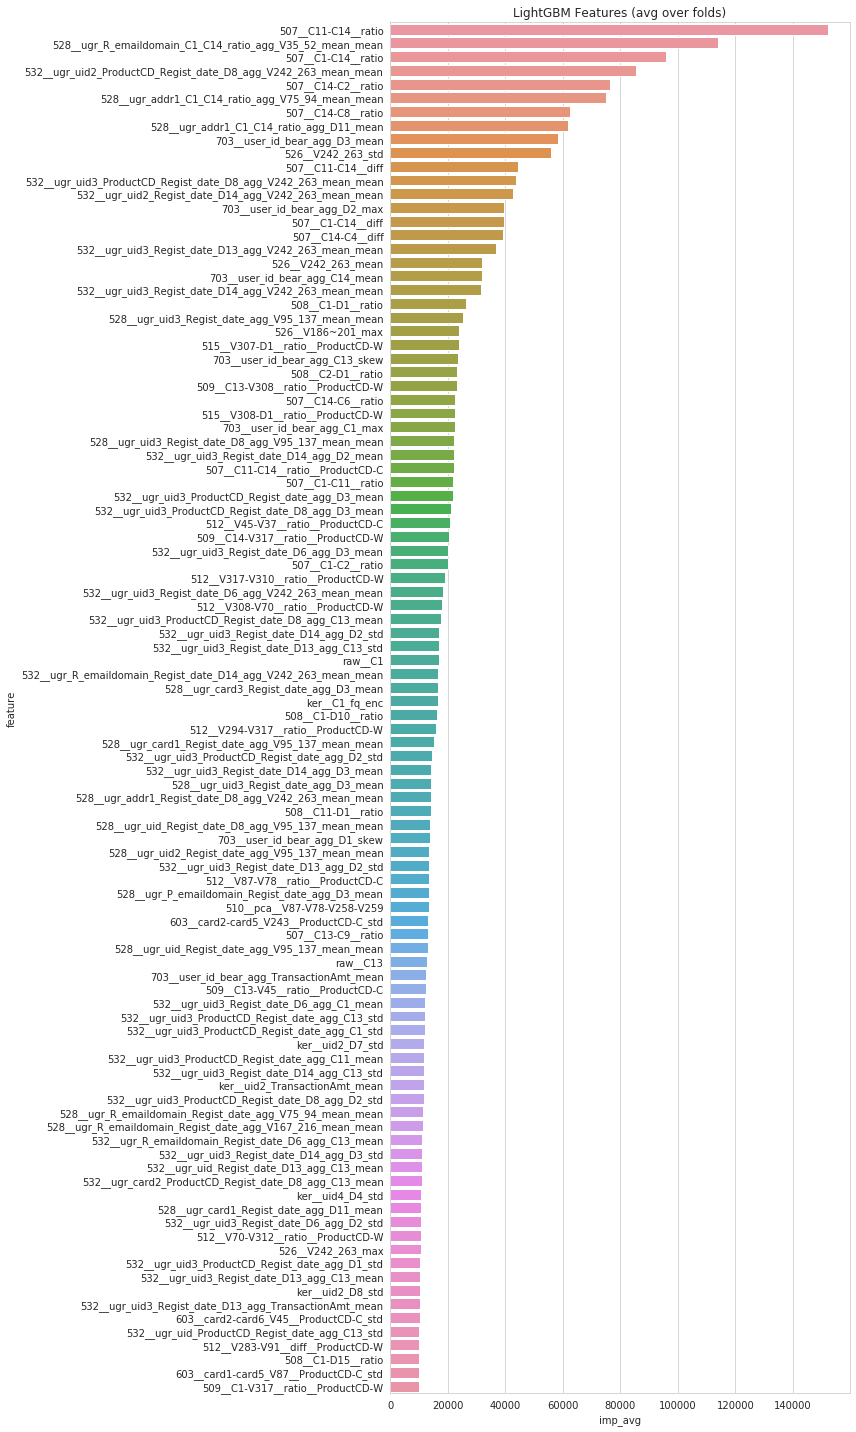

KeyError: 'seed'

In [5]:
feim, _ = eval_train(
    logger,
    tmp_train,
    Y,
    tmp_test,
    COLUMN_GROUP,
    model_type,
    params,
    is_adv=[True, False][1],
    is_viz=[True, False][0],
)
feim = list_result_feim[0]

In [17]:
# bear = pd.read_csv('../output/same_user_pattern/20190901_user_ids_share.csv')
bear.head()

,TransactionID,is_multi_section_user,fixed_D1,section_id,section_row_id,predicted_user_id
0,3189865,NaN,NaN,NaN,NaN,NaN
1,3194665,NaN,NaN,NaN,NaN,NaN
2,3241275,NaN,NaN,NaN,NaN,NaN
3,3251171,NaN,NaN,NaN,NaN,NaN
4,3322570,NaN,NaN,NaN,NaN,NaN


In [20]:
# probing[probing['TransactionID']==3421965]
bear[bear['TransactionID'].isin(ids)].sort_values(by=COLUMN_ID)[[COLUMN_ID, 'predicted_user_id']]

,TransactionID,predicted_user_id
354062,3421965,97701.0
354063,3421966,97701.0
354064,3421968,97701.0
354065,3427288,97701.0
354066,3432633,97701.0
354074,3432653,97703.0
354075,3432877,97703.0
354067,3433038,97701.0
354068,3433041,97701.0
354069,3434804,97701.0


In [13]:
probing = pd.read_csv('../input/20190929_probing.csv')
no_probing = pd.read_csv('../input/20190929_no_probing.csv')
ids = [
3421965,
3421966,
3421968,
3427288,
3432633,
3432653,
3432877,
3433038,
3433041,
3434804,
3437210,
3437213,
3438228,
3438381,
3438382,
3439573,
3447033,
3469633,
]
probing[probing['TransactionID'].astype('int').isin(ids)]
no_probing[no_probing['TransactionID'].astype('int').isin(ids)]

,TransactionID,transaction_time,user_id,data_type,Probing_isFraud


In [ ]:
feim = list_result_feim[0]
# feim = read_pkl_gzip('../output/feature_importances/20190926_1350__CV0-9604930198337085__feature1942.gz')
# feim = read_pkl_gzip('../output/feature_importances/20190925_1450__CV0-9581588018233685__feature2114.gz')
# key1 = '532_'
# key2 = '_D'

# idx = [col for col in feim.index if
#        (
#        col.count(key1)
# #        and
#        or
#        col.count(key2)
#        )
#        and not col.count('ratio')
#        and not col.count('diff')
#       ]
# feim = feim.loc[idx]
# feim.sort_values(by='imp_avg', inplace=True, ascending=False)
# print(feim.shape)
# feim.tail(100)
feim

In [9]:
cnt = 0
# feim = read_pkl_gzip('../output/feature_importances/20190909_2324__CV0-9467296784440689__feature552.gz')
for feature_name in feim.index:
# for feature_name in feim.tail(100).index:
# for feature_name in feim[feim['imp_avg']<6000].index:
    
    if not feature_name.count('mean'):
        continue

    if feature_name.count('raw'):
        from_dir = 'raw_use'
        to_dir = 'raw_trush'
#         from_dir = 'raw_trush'
#         to_dir = 'raw_use'
    else:
        from_dir = 'org_use'
        to_dir = 'org_trush'
#         from_dir = 'org_trush'
#         to_dir = 'org_use'
#     from_dir = 'product_feature'
#     from_dir = 'kernel'
#     from_dir = 'check_trush'
#     from_dir = 'raw_trush'
#     from_dir = 'raw_use'
#     from_dir = 'org_trush'
#     from_dir = 'useless'
    from_dir = '../submit/re_sub'
#     from_dir = '../submit/add_feature/'
#     from_dir = 'org_use'
#     from_dir = 'valid_use'
#     from_dir = 'valid_trush'
#     to_dir = '../submit/escape'
#     to_dir = '../submit/add_feature'
#     to_dir = '../submit/add_feature'
#     to_dir = 'valid_trush'
#     to_dir = 'valid_use'
#     to_dir = 'raw_trush'
#     to_dir = 'check_trush'
#     to_dir = 'org_use'
#     to_dir = 'useless'
#     to_dir = 'valid'
#     to_dir = 'kernel'
    try:
#         print(feature_name)
        move_feature([feature_name], from_dir, to_dir)
        cnt+=1
    except FileNotFoundError:
        print(feature_name)
print(cnt)

NameError: name 'feim' is not defined

In [ ]:
is_submit = [True, False][0]
has_dec = [True, False][0]
n_splits = 6
set_type = 'new_set'

valid_paths_train = paths_train_feature[:]
valid_paths_test  = paths_test_feature[:]

#========================================================================
# pathの存在チェック。なぜかたびたびFileNotFoundErrorが起きるので,,,
#========================================================================
remove_paths = []
for trn_path, tes_path in zip(valid_paths_train, valid_paths_test):
    if os.path.exists(trn_path) and os.path.exists(tes_path):
        pass
    else:
        remove_paths.append(trn_path)
        remove_paths.append(tes_path)
for path in remove_paths:
    if path.count('train'):
        valid_paths_train.remove(path)
        print(f'remove {path}')
    elif path.count('test'):
        valid_paths_test.remove(path)
        print(f'remove {path}')

if len(valid_paths_train):
    df_feat_train = parallel_load_data(valid_paths_train)
    df_feat_test  = parallel_load_data(valid_paths_test)
    
    col_drops = eval_check_feature(df_feat_train, df_feat_test)
    
    tmp_train = df_train.join(df_feat_train)
    tmp_test = df_test.join(df_feat_test)
else:
    tmp_train = df_train
    tmp_test = df_test

#========================================================================
# Train Test で片方に存在しないFeatureを除外
#========================================================================
diff_cols = list(set(tmp_train.columns) - set(tmp_test.columns))

for col in list(set(diff_cols)):
    from_dir = 'valid'
    to_dir = 'valid_trush'
    move_feature([col], from_dir, to_dir)
tmp_train.drop(diff_cols, axis=1, inplace=True)
print(f"  * Diff Features: {len(diff_cols)}")

# same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
# same_user_path = '../output/same_user_pattern/0902__same_user_id__card_addr_pemail_M.csv'
group_kfold_path = '../input/0908_ieee__DT-M_GroupKFold.gz'
group = read_pkl_gzip(group_kfold_path)
tmp_train[COLUMN_GROUP] = group

# 2017-12抜いてみる
# if not has_dec:
#     tmp_train = tmp_train[tmp_train[COLUMN_GROUP]!='2017-12']
#     Y = Y.loc[tmp_train.index]
#     n_splits = 5


#========================================================================
# Features elimination 
#==============================================================
# from scipy.stats import ks_2samp
# features_check = []
# columns_to_check = set(list(tmp_train)).difference(COLUMNS_IGNORE)
# for i in columns_to_check:
#     features_check.append(ks_2samp(tmp_test[i], tmp_train[i])[1])

# features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
# features_discard = list(features_check[features_check==0].index)
# print(features_discard)
# tmp_train.drop(features_discard, axis=1, inplace=True)
# tmp_test.drop(features_discard, axis=1, inplace=True)


model_type = "lgb"
params = {
#     'n_jobs': 60,
    'n_jobs': 96,
#     'n_jobs': 84,
#     'n_jobs': 48,
#     'n_jobs': 36,
    'objective': 'binary',
    'num_leaves': 2**8-1,
    'max_depth': -1,
    'subsample': 0.7,
    'subsample_freq': 1,
    'colsample_bytree' : 0.10,
    'lambda_l1' : 0.1,
    'lambda_l2' : 1.0,
    'learning_rate' : 0.1,
    "early_stopping_rounds": 50,
    "seed": 1208,
    "bagging_seed": 1208,
    "feature_fraction_seed": 1208,
    "drop_seed": 1208,
    'n_splits': n_splits,
    'metric': 'auc',
    'model_type': model_type,
    'fold': ['stratified', 'group'][1],
}
if is_submit:
    params['learning_rate'] = 0.01
#     params['learning_rate'] = 0.05
    params["early_stopping_rounds"] = 100

logger.info(f"* EXP: dataset {set_type} {tmp_train.shape} lr {params['learning_rate']} ")

list_result_feim = eval_train(
    logger,
    tmp_train,
    Y,
    tmp_test,
    COLUMN_GROUP,
    model_type,
    params,
    is_adv=[True, False][1],
    is_viz=[True, False][0],
)
feim = list_result_feim[0]

  * Diff Features: 1


2019-09-29 06:04:52,252 func.utils 111 [INFO]    [<module>] * EXP: dataset new_set (590540, 1682) lr 0.01  


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.905843
[400]	valid_0's auc: 0.919909
[600]	valid_0's auc: 0.926924
[800]	valid_0's auc: 0.930362
